# Visualization Best Practices in R

https://learn.datacamp.com/courses/visualization-best-practices-in-r

In [2]:
library(ggplot2)
library(dplyr)
library(tidyr)
options(jupyter.plot_mimetypes = "image/svg+xml") # for better graphics

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Let us download the dataset containing disease cases from the World Health Organization (WHO).

In [3]:
who_disease <- read.csv("https://assets.datacamp.com/production/repositories/1864/datasets/71386124a72f58a50fbc07b8254f47ef9a867ebe/who_disease.csv", header=TRUE, stringsAsFactors=FALSE)

In [4]:
head(who_disease)

region,countryCode,country,disease,year,cases
EMR,AFG,Afghanistan,measles,2016,638
EUR,ALB,Albania,measles,2016,17
AFR,DZA,Algeria,measles,2016,41
EUR,AND,Andorra,measles,2016,0
AFR,AGO,Angola,measles,2016,53
AMR,ATG,Antigua and Barbuda,measles,2016,0


## Proportions of a whole

### Stacked bar chart

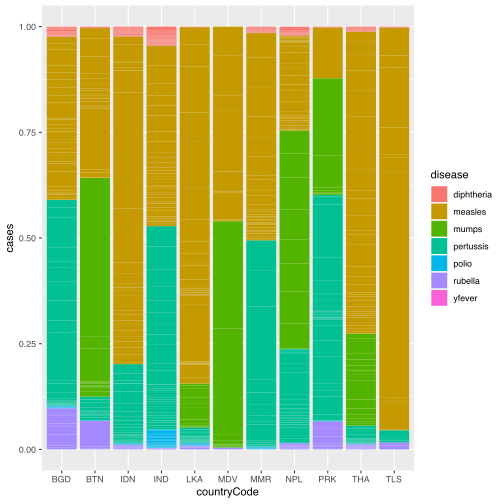

In [12]:
who_disease %>%
    filter(region == "SEAR") %>%
    ggplot(aes(x = countryCode, y = cases, fill = disease)) + 
    geom_col(position = "fill")

We're interested in looking at patterns over time. To do this we will make a stacked bar chart with the x-axis being the year of observation. We will simplify the data to just be measles, mumps, and other.

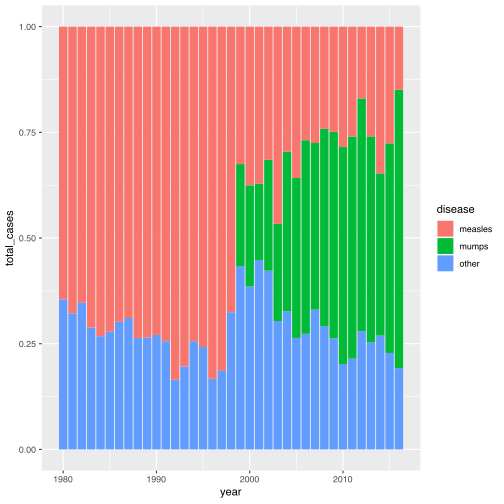

In [13]:
disease_counts <- who_disease %>%
    mutate(disease = ifelse(disease %in% c('measles', 'mumps'), disease, 'other')) %>%
    group_by(disease, year) %>%
    summarise(total_cases = sum(cases))

ggplot(disease_counts, aes(x = year, y = total_cases, fill = disease)) +
    # Change the position argument to make bars full height
    geom_col(position = "fill")

Since we grouped all diseases that are not measles and mumps into their own category, it's fair to assume that we care less about the 'other' category's trajectory than those of measles and mumps.

Because of this, the plot we made has a problem. The way that the bars are stacked, with measles on top, mumps in the middle, and other on the bottom, makes it hard to get a good intuition for the behavior of mumps over time because its baseline is non-constant due to changing values in measles proportions.

Ggplot orders the bars and legend based upon the order it sees the variables in the dataset. To override this, we'll turn the disease column into a factor with the levels in the order we want our plot to use.

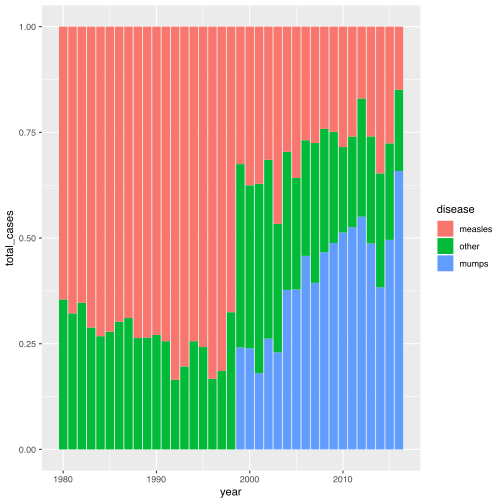

In [16]:
disease_counts <- who_disease %>%
    mutate(
        disease = ifelse(disease %in% c('measles', 'mumps'), disease, 'other') %>%
        factor(levels = c('measles', 'other', 'mumps')) # change factor levels to desired ordering 
    ) %>%
    group_by(disease, year) %>%
    summarise(total_cases = sum(cases)) 

ggplot(disease_counts, aes(x = year, y = total_cases, fill = disease)) +
    geom_col(position = 'fill')

We see that mumps didn't start getting reported until 1999, making comparisons before then meaningless.

Let's filter the data to be only the cases reported on or after 1999 and then make a stacked bar chart looking at the proportion of different diseases by region.

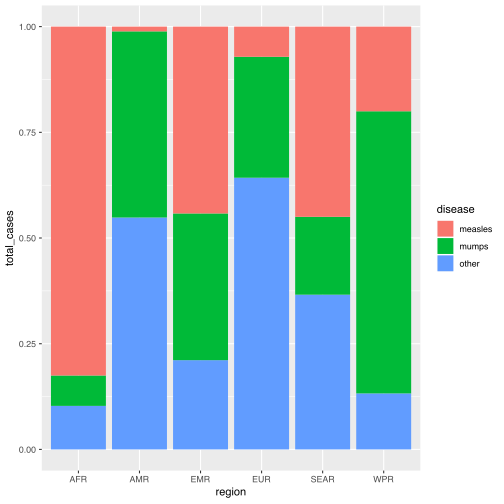

In [17]:
disease_counts <- who_disease %>%
    filter(year >= 1999) %>% 
    mutate(disease = ifelse(disease %in% c('measles', 'mumps'), disease, 'other')) %>%
    group_by(disease, region) %>%
    summarise(total_cases = sum(cases))

ggplot(disease_counts, aes(x = region, y = total_cases, fill = disease)) +
    geom_col(position = "fill")

## Point data

That is one is categorical value, and other is numerical.

### Bar plots

In ggplot, there are two different ways to make bar plots: geom_col() and geom_bar().

If your data is in the form where the height of the bar is encoded in a column that you want to map to the y-axis, like counts of diseases are in our data, you want to use the geom_col() option.

Let's make a barplot of the number of cases recorded by disease for India in 1980 using geom_col().


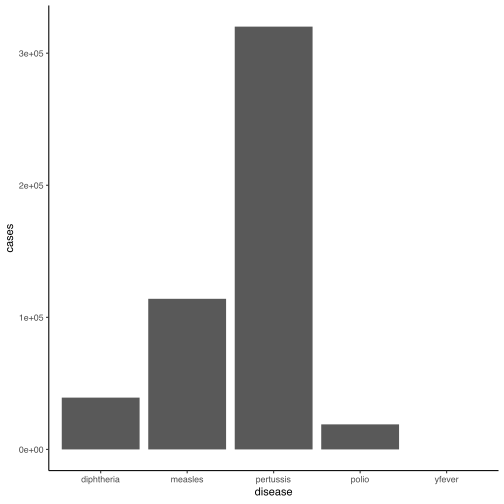

In [18]:
who_disease %>% 
    filter(country == "India", year == 1980) %>% 
    ggplot(aes(x = disease, y = cases)) +
    geom_col() + 
    theme_classic()

Whereas geom_col() expects you to pass it a y-axis mapping column, geom_bar() doesn't take a y-axis call (at least by default).

Instead, geom_bar() takes your x-axis mapping and counts every single observation (or row of the passed dataframe) for each class and then draws bars of corresponding heights

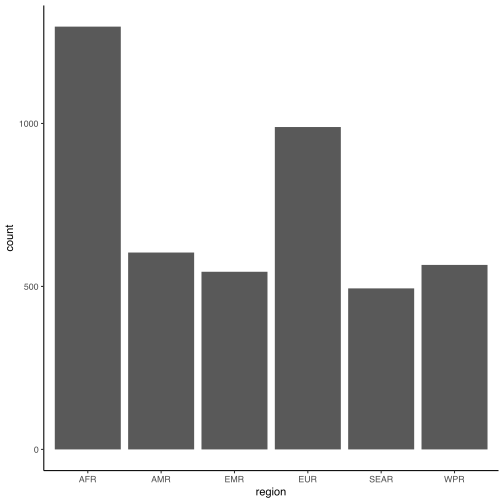

In [21]:
who_disease %>%
    filter(cases > 1000) %>%
    ggplot(aes(x = region)) +
    geom_bar() + 
    theme_classic()

### Point charts

In [25]:
interestingCountries <- c(
    "NGA", "SDN", "FRA", "NPL", "MYS",
    "TZA", "YEM", "UKR", "BGD", "VNM"
)

who_subset <- who_disease %>%
    filter(
        countryCode %in% interestingCountries,
        disease == 'measles',
        year %in% c(1992, 2002)
    ) %>%
    mutate(year = paste0('cases_', year)) %>%
    spread(year, cases)

who_subset

region,countryCode,country,disease,cases_1992,cases_2002
AFR,NGA,Nigeria,measles,85965,42007
AFR,TZA,United Republic of Tanzania,measles,13040,5131
EMR,SDN,Sudan (the),measles,17017,4529
EMR,YEM,Yemen,measles,2420,890
EUR,FRA,France,measles,109548,5185
EUR,UKR,Ukraine,measles,13289,7587
SEAR,BGD,Bangladesh,measles,5768,3484
SEAR,NPL,Nepal,measles,136,6749
WPR,MYS,Malaysia,measles,363,408
WPR,VNM,Viet Nam,measles,11830,6755


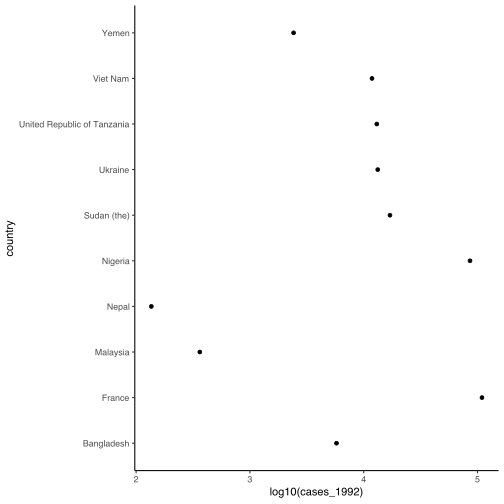

In [26]:
ggplot(who_subset, aes(x = log10(cases_1992), y = country)) +
    geom_point() +
    theme_classic()

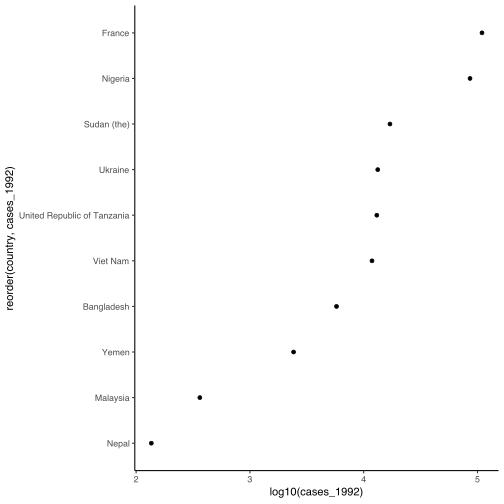

In [27]:
ggplot(who_subset, aes(x = log10(cases_1992), y = reorder(country, cases_1992))) +
    geom_point() +
    theme_classic()

A nice property of the log fold change is it is symmetric: a value of 1 means two times 'bigger', and -1 means two times 'smaller.' Due to this, the position of 0 on the x-axis marks the switch point between count declines and increases over years. When your data has a natural break-point like this, it is good if the chart shows it as a focal-point as well.

The code provided will make a basic point chart of the log fold change for the dates. To improve it, we will do two things. First, reorder the dots in descending order like in the previous exercise. Second, add a guideline at x = 0 to show the neutral point by adding geom_vline() (for verticalline) to your plot object with the argument xintercept set to 0.

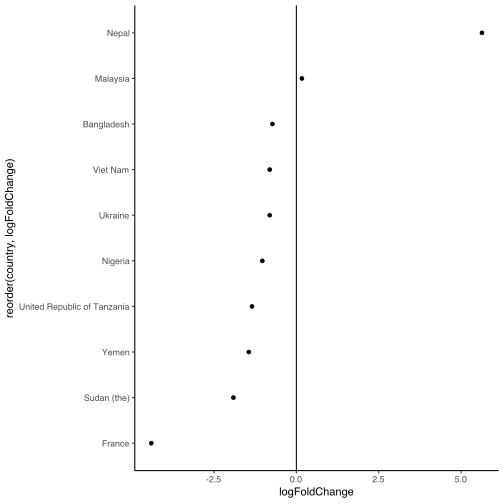

In [35]:
who_subset %>% 
    mutate(logFoldChange = log2(cases_2002/cases_1992)) %>% 
    ggplot(aes(x = logFoldChange, y = reorder(country, logFoldChange))) +
    geom_point() +
    geom_vline(xintercept = 0) + 
    theme_classic()

Taking the code from the last exercise, let's modify it to group the countries by their region by faceting.

This will help inject a bit more structure into the presentation while not overly complicating the chart.

We want to use facet_grid() here and keep all the plots in the same column, enabling easy comparisons outside of a region while still maintaining the region-level grouping.

You will also need to adjust the scale argument in facet_grid() in order to avoid repeating the entire y-axis structure for every facet.

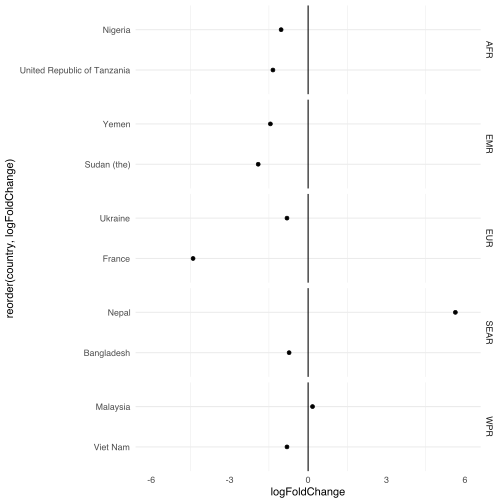

In [36]:
who_subset %>% 
    mutate(logFoldChange = log2(cases_2002/cases_1992)) %>% 
    ggplot(aes(x = logFoldChange, y = reorder(country, logFoldChange))) +
    geom_point() +
    geom_vline(xintercept = 0) +
    xlim(-6,6) +
    facet_grid(region~., scales = 'free_y') + 
    theme_minimal() + 
    theme(
        panel.grid.major.x = element_blank()
    )

Only the Western Pacific Region (WPR) and South East Asian Region (SEAR) have growth. Just like adding the anchoring line in the last exercise helped subtly improve the plot, so does faceting on interesting hierarchies in the data.

### Tuning charts

#### Busy charts

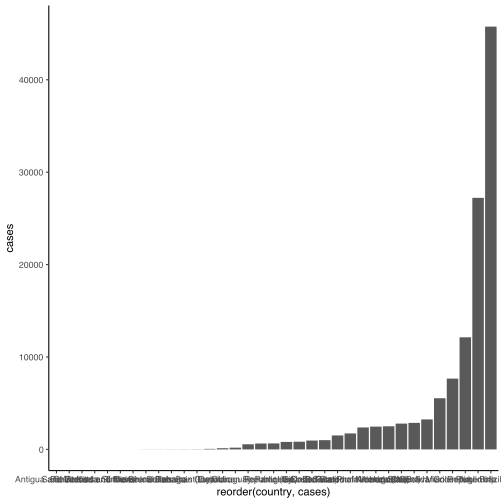

In [40]:
amr_pertussis <- who_disease %>% 
    filter(   # filter data to our desired subset
        region == 'AMR', 
        year == 1980, 
        disease == 'pertussis'
    )

ggplot(amr_pertussis, aes(x = reorder(country, cases), y = cases)) +
    geom_col() +
    theme_classic()

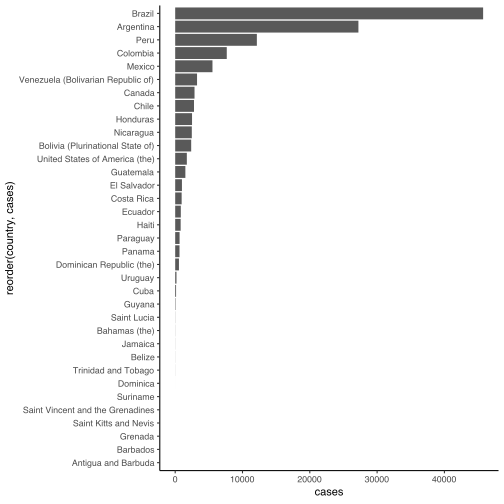

In [43]:
ggplot(amr_pertussis, aes(x = reorder(country, cases), y = cases)) +
    geom_col() +
    # flip axes
    coord_flip() + 
    theme_classic()

This tiny bit of code has taken an impossible to read barchart into a fascinating and clear story. Notice how after Uruguay, we basically can't see the bars because they are so small, what's a way we could fix this? Let's get rid of these to free up even more space for the country names to breath.

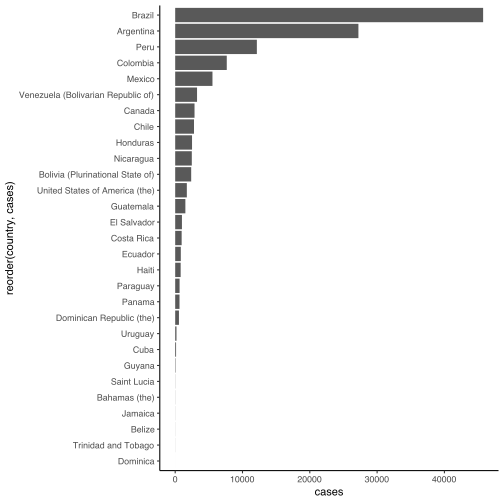

In [44]:
amr_pertussis %>% 
    # filter to countries that had > 0 cases. 
    filter(cases > 0) %>%
    ggplot(aes(x = reorder(country, cases), y = cases)) +
    geom_col() +
    coord_flip() +
    theme_classic()

Now that we've actually filtered out the zero counts, we see that some of the countries still don't have noticable bars.

What if we care about the values of the lower-end of the cases? It's hard for us to get a sense of their values because Brazil and Argentina are forcing the axis' upper range so high.<br>
This is a good situation to switch to a log scale. However, remember that when on a log scale our stacking concept fails, so we should switch to a point chart! _Note the additional filter added to the pipeline. What happens if you run the code without it?_

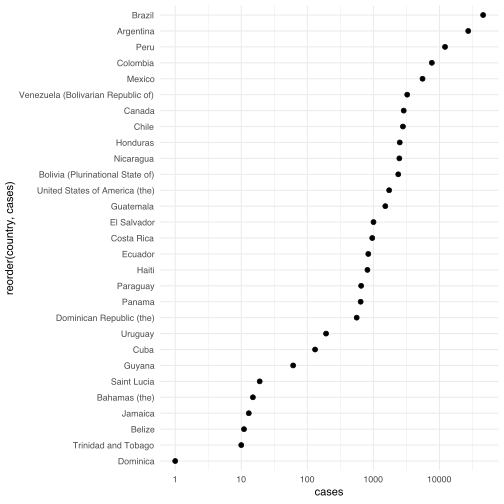

In [46]:
amr_pertussis %>% filter(cases > 0) %>% 
    ggplot(aes(x = reorder(country, cases), y = cases)) + 
    # switch geometry to points and set point size = 2
    geom_point(size = 2) + 
    # change y-axis to log10. 
    scale_y_log10() +
    theme_minimal() +
    coord_flip()